# Unsupervised Machine Learning using GEE Python API + geemap Library

In this assignment, we are tasked to perform a simple unsupervised machine learning algorithm to cluster the satellite imagery of a study area using the GEE Python API and geemap Python package.

We retrieved satellite imageries of the Netherlands as the study area using GEE Python API and performed reduce operation to get a single imagery for the clustering. We applied K-means clustering algorithm to the imagery and validated the resultant data to the provided reference data point from CSV files.

Lastly, we provided arguments over some discussion points about how the unsupervised machine learning performed from several perspectives.

Below are our step-by-step of how we fulfilled the required tasks to finish the assignment.

## Selecting Study Area

Firstly, below are all Python modules we used in the assignment.

In [1]:
import pandas as pd
import glob
from countryboundingboxes import country_bounding_boxes

import ee
import geemap

import geopandas as gpd
import matplotlib.pyplot as plt

Below are the steps to select the study area, apply a mask from the bounding box to filter reference points imported from CSV data, and convert them into GeoPandas to prepare for geospatial purposes.

In [2]:
# Compiling CSV sample data to one dataframe using Pandas
all_csv = glob.glob("./data/*.csv")
df_csv = pd.concat((pd.read_csv(csv) for csv in all_csv))
df_csv

,lat,lon,landcover
0,40.582904,-22.166310,ForestNaturalAreas
1,57.591202,-5.168274,AgriculturalArea
2,70.850927,-9.175052,ForestNaturalAreas
3,37.519676,32.485142,AgriculturalArea
4,50.582377,-7.032158,ArtificialSurfaces
...,...,...,...
4013,45.359292,19.185816,Water
4014,59.992077,16.333949,ForestNaturalAreas
4015,47.464372,10.852922,AgriculturalArea
4016,42.322929,-15.896878,AgriculturalArea


In [3]:
# Selecting the country
countrycode='NL'

In [4]:
# Selecting country's bounding box
bbox = country_bounding_boxes[countrycode][1]

# Extracting min & max longitude and latitude from the bounding box
min_lon = bbox[0]
min_lat = bbox[1]
max_lon = bbox[2]
max_lat = bbox[3]
bbox

(3.31497114423, 50.803721015, 7.09205325687, 53.5104033474)

In [5]:
# Creating mask for filtering CSV data using the bounding box
mask = (
    (df_csv['lat'] >= min_lat) & (df_csv['lat'] <= max_lat) &
    (df_csv['lon'] >= min_lon) & (df_csv['lon'] <= max_lon))

# Applying the mask to filter the CSV
df = df_csv[mask]
df

,lat,lon,landcover
80,53.013246,3.497340,AgriculturalArea
107,51.780871,6.460150,ForestNaturalAreas
179,51.691521,4.668549,ForestNaturalAreas
415,51.876503,4.155372,AgriculturalArea
417,51.104469,5.315605,AgriculturalArea
...,...,...,...
3264,51.938681,3.349975,AgriculturalArea
3570,51.943123,4.140162,AgriculturalArea
3662,52.461430,5.418577,AgriculturalArea
3857,51.163087,4.179379,ForestNaturalAreas


In [6]:
# Check how many landcovers in the study area
df['landcover'].unique()

array(['AgriculturalArea', 'ForestNaturalAreas', 'ArtificialSurfaces',
       'Water', 'Wetlands'], dtype=object)

In [7]:
# Converting the filtered dataframe to GeoPandas
geometry = gpd.points_from_xy(df['lon'], df['lat'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs = "EPSG:4326")
gdf

,lat,lon,landcover,geometry
80,53.013246,3.497340,AgriculturalArea,POINT (3.49734 53.01325)
107,51.780871,6.460150,ForestNaturalAreas,POINT (6.46015 51.78087)
179,51.691521,4.668549,ForestNaturalAreas,POINT (4.66855 51.69152)
415,51.876503,4.155372,AgriculturalArea,POINT (4.15537 51.87650)
417,51.104469,5.315605,AgriculturalArea,POINT (5.31560 51.10447)
...,...,...,...,...
3264,51.938681,3.349975,AgriculturalArea,POINT (3.34997 51.93868)
3570,51.943123,4.140162,AgriculturalArea,POINT (4.14016 51.94312)
3662,52.461430,5.418577,AgriculturalArea,POINT (5.41858 52.46143)
3857,51.163087,4.179379,ForestNaturalAreas,POINT (4.17938 51.16309)


## Image & Feature Collection

In this phase, we used Google Earth Engine Python API to start the imagery processing. We performed reduce operation to retrieve median image from all satellite imageries of the Netherlands during summer 2023. Lastly, we showed the distribution of the reference points onto the imagery.

Below are the steps taken.

In [8]:
# Trigger the authentication flow. Remove the commented line below and run this cell to trigger.
# ee.Authenticate()

In [9]:
# Initialize GEE
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


In [10]:
# Define the region and summer time frame
roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
startDate = '2023-06-21'
endDate = '2023-09-23'

# Load the Landsat collection
image = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(roi) \
    .filterDate(startDate, endDate) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)

# Show the number of images
imageCount = image.size().getInfo()
imageCount

100

In [11]:
# Calculate the median image for the entire collection
medianImage = image.reduce(ee.Reducer.median())

In [12]:
# Display the median image
Map = geemap.Map()
Map.centerObject(roi, 8)

Map.addLayer(medianImage, {
    'bands': ['B4_median', 'B3_median', 'B2_median'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}, 'Median Image')

In [13]:
# Create polygon of bounding box
mapbbox = ([min_lon, min_lat], [max_lon, min_lat], [max_lon, max_lat], [min_lon, max_lat])
region = ee.Geometry.Polygon(mapbbox)

In [14]:
# Convert GeoDataFrame to an Earth Engine FeatureCollection
ee_collection = geemap.geopandas_to_ee(gdf)

# Add the FeatureCollection to the map
Map.addLayer(ee_collection, {'color' : 'red'}, 'GeoDataFrame Points')

# Center the map on the GeoDataFrame
Map.centerObject(ee_collection)

# Display the map
Map

Map(center=[52.15841316394718, 5.203512200550043], controls=(WidgetControl(options=['position', 'transparent_b…

## K-Means Clustering

In this phase, we used K-Means clustering algorithm using the samples training data to cluster the imagery. We sampled 5,000 pixels from the image as the training data. Later in this note, we compared the results of using those trained data for clustering with 420 validated reference points from the CSV files.

Below are the steps taken.

In [15]:
# Sample training data from the imagery for clustering purpose 
training = medianImage.sample(**{
    'region': region,
    'scale': 30,
    'numPixels': 5000,
    'seed': 0,
    'geometries': True,
    'tileScale': 2
})

# Show the training data onto the map
Map.addLayer(training, {'color':'blue'}, 'training')
Map

Map(center=[52.15841316394718, 5.203512200550043], controls=(WidgetControl(options=['position', 'transparent_b…

In [16]:
# Define the amount of clusters
n_clusters = 7

In [17]:
%time
# Create k-means clustering model & use it to cluster the image
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)
result = medianImage.cluster(clusterer)

CPU times: user 8 µs, sys: 12 µs, total: 20 µs
Wall time: 38.1 µs


In [18]:
# Add the cluster result to map
Map.addLayer(result.randomVisualizer(), {}, 'clusters')

## Cluster Validation

In this phase, we compared the cluster result to a validated data and saw how the quality of the clustered result is in separating landcover from the imagery. We plotted histograms of all validated landcovers for each clusters and observed how the landcover distribution.

Below are the steps taken.

In [19]:
# Retrieving cluster information from imagery onto the reference points
cluster_samples = result.sampleRegions(**{
    'collection':ee_collection, 
    'properties':['landcover'],
    'scale':30,
    'tileScale':2
    })

# Convert the new GEEMAP object to GeoPandas for plotting purpose
cluster_samples_pd = geemap.ee_to_geopandas(cluster_samples)
cluster_samples_pd

,geometry,cluster,landcover
0,None,6,AgriculturalArea
1,None,5,ForestNaturalAreas
2,None,1,ForestNaturalAreas
3,None,1,AgriculturalArea
4,None,2,AgriculturalArea
...,...,...,...
415,None,6,AgriculturalArea
416,None,2,AgriculturalArea
417,None,0,AgriculturalArea
418,None,2,ForestNaturalAreas


In [20]:
# Group the data by 'cluster' and 'landcover' and count occurrences
histogram_data = cluster_samples_pd.groupby(['cluster', 'landcover']).size().unstack()

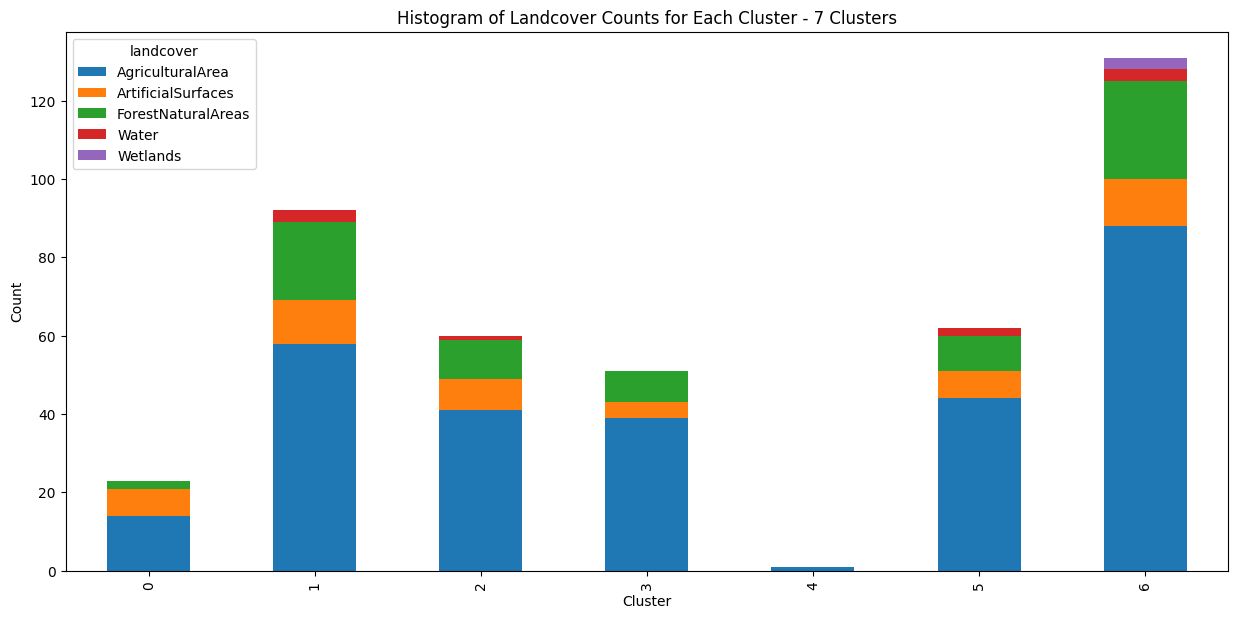

In [21]:
# Plot the histograms
hist = histogram_data.plot(kind='bar', stacked='True', figsize=(15,7))
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title(f'Histogram of Landcover Counts for Each Cluster - {n_clusters} Clusters')
plt.savefig(f'histogram_plot_{n_clusters}clusters_{countrycode}.png')

plt.show()

## Discussion

In this section, we observed and discussed some points based on the clustering result performed above. 

### Why do we need to train an unsupervised classifier in GEE

Training an unsupervised classifier, k-means clustering in this case, is useful for analyzing Earth observation data without relying on labeled samples. Unsupervised classification is particularly helpful when labeled training data is scarce or unavailable. In GEE, this technique provides insights and helps in analyzing Earth observation data when labeled training samples are not readily available.

### Impact of the number clusters on the results

Below are the results of validation step of the K-Means clustering algorithm performed for several number of K. 

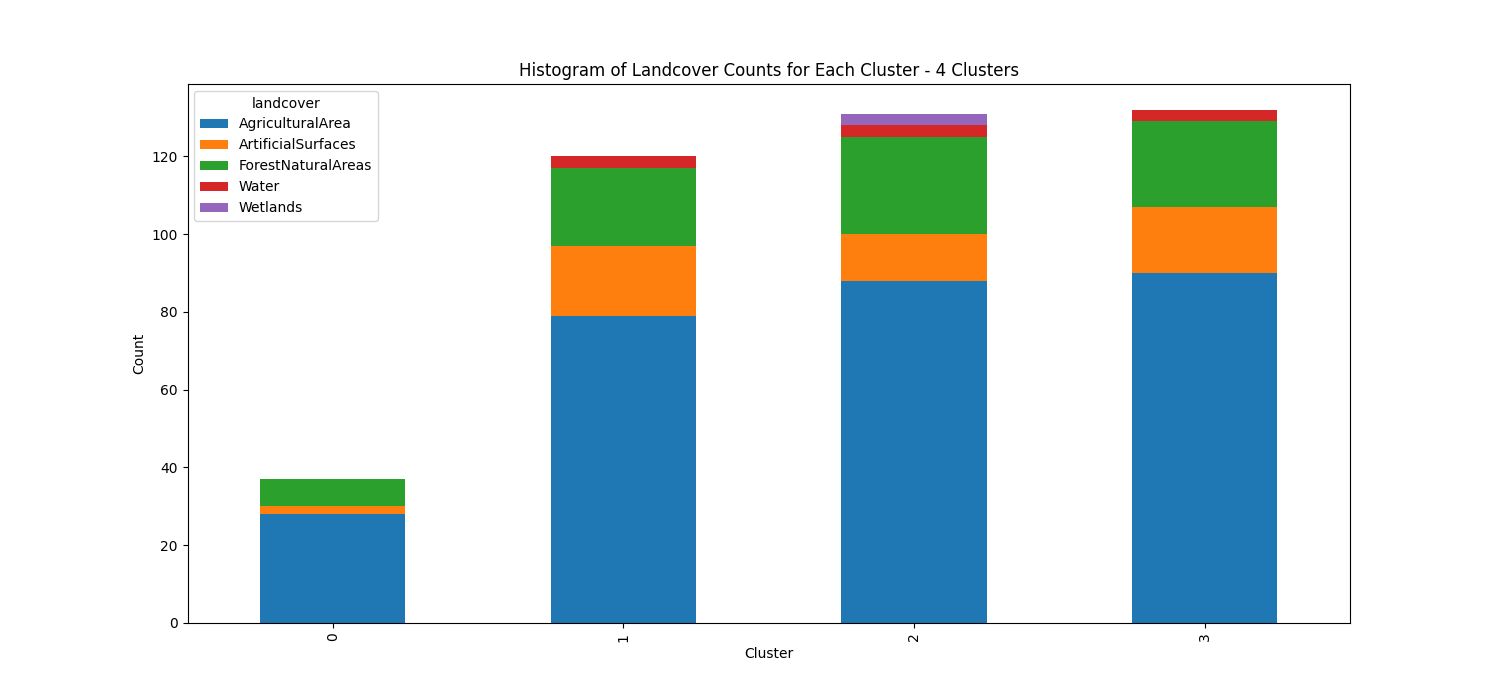

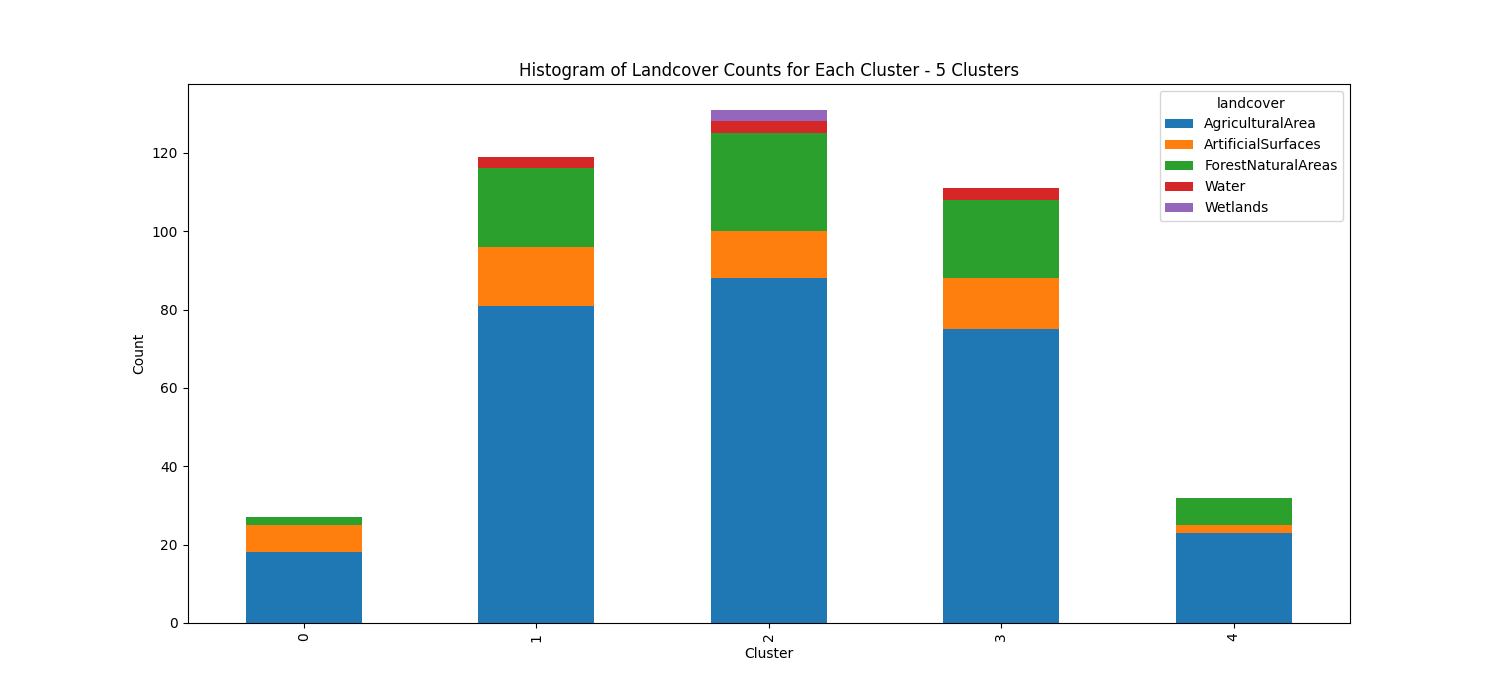

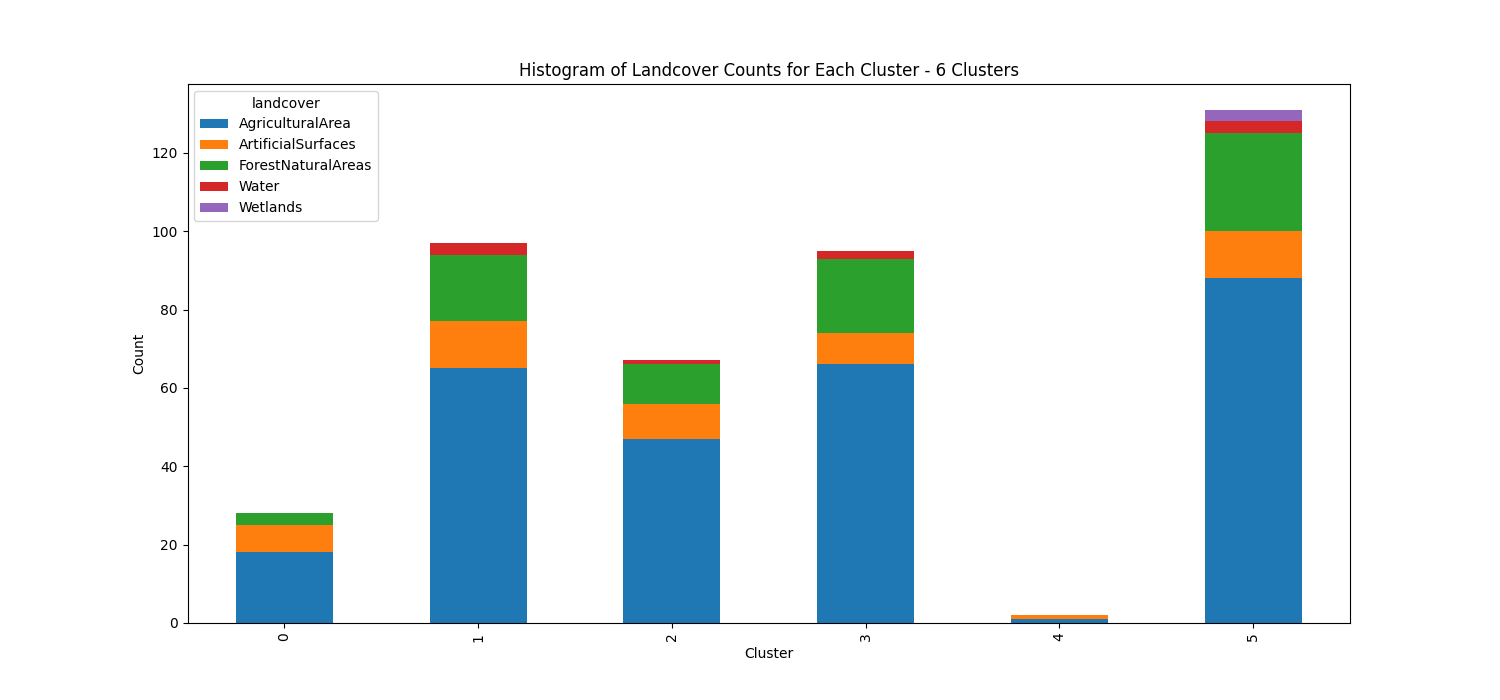

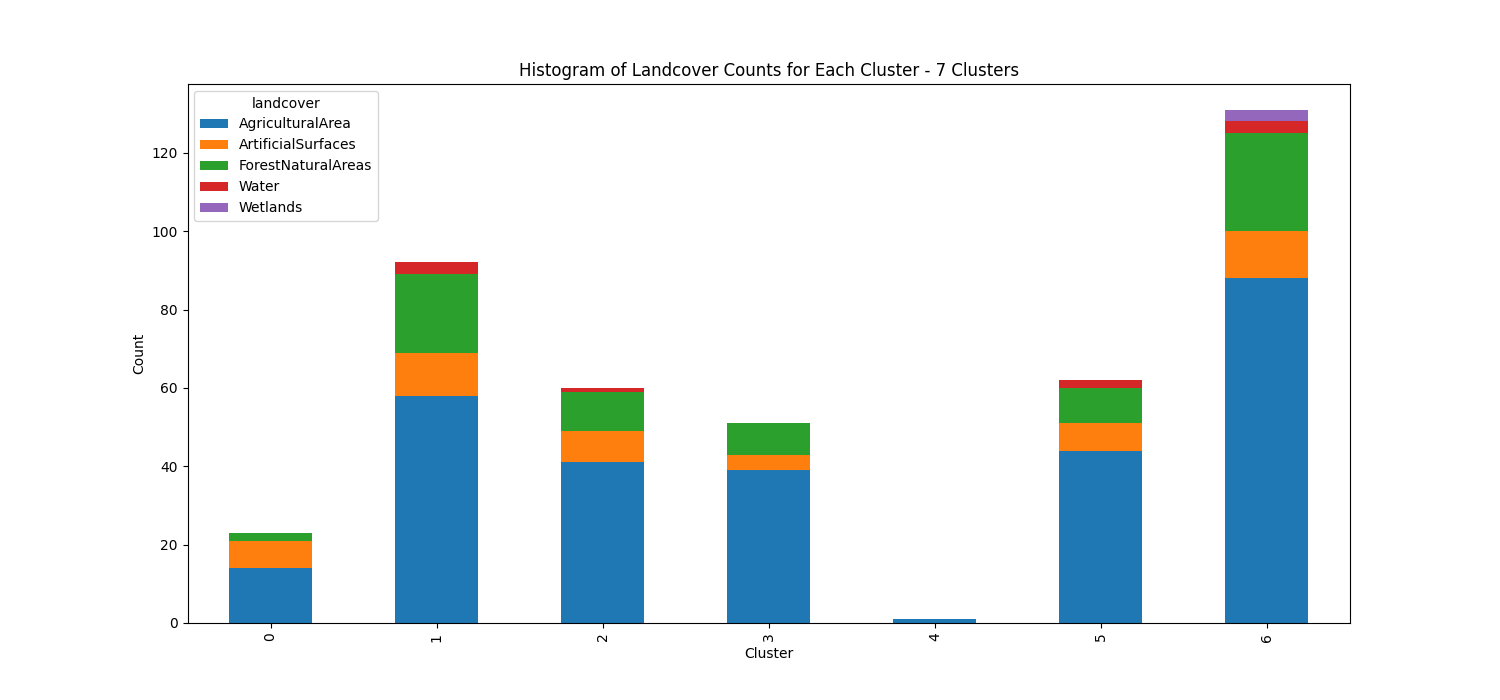

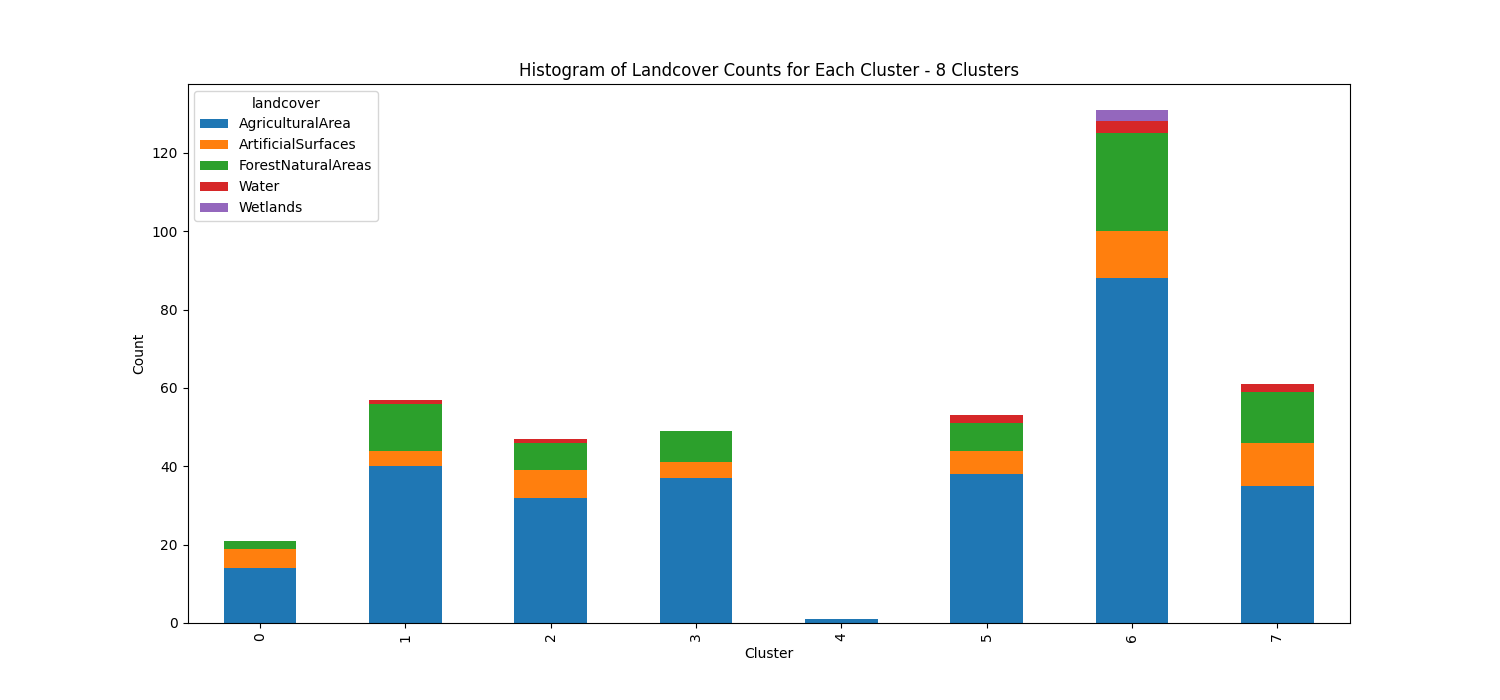

As we can see from the histograms above, 'Agricultural Area' dominates almost all clusters in all iterations. This might be because of the reference points for this type of landcover are located in various places with various pixel values, therefore being included in most clusters.

The same issue also happens to other landcover types that have similarly distributed manner throughout the clusters. The issues make it difficult to determine whether one cluster represent a certain landcover (which should be the ideal case).

The issues indicate an underperforming cluster algorithm being executed in all iterations. It is also difficult to determine which number of cluster is the best one for our case since all clutering iterations show similar results.

### Computational time

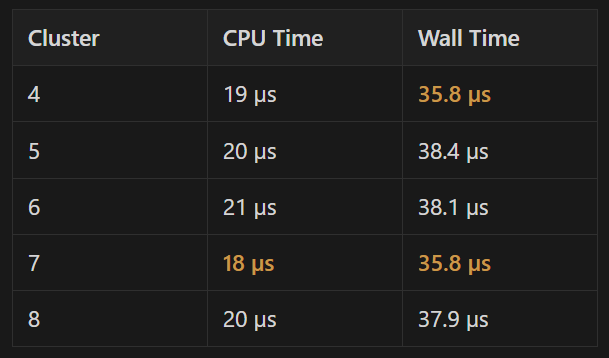

Above is the amount of time to create the cluster model and use it to cluster the whole image. We are not using distributed computing like Dask in our assignment since it is possible to run the whole clustering assignment without it.

The table above shows that each clustering iterations have no significant timegap between each other. The 7 cluster iteration has the fastest clustering computation of all iterations. 

Knowing that having exact cluster number as the landcover types (5) or having less cluster (4) do not mean faster computation, we observed no clear relation between the number of clusters to each computation time.

### Impact of performing the clustering in region X and applying it on region Y

In this discussion, we used the training model generated from Region X (the Netherlands) and use it on another area we can call Region Y, in this case is Germany.

Below are the codes to attempt this case.

In [22]:
# Define the amount of clusters
n_clusters = 5

# Create k-means clustering model
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

In [23]:
# Selecting the country for Region Y
countrycode='DE'

In [24]:
# Compiling CSV sample data to one dataframe
all_csv = glob.glob("./data/*.csv")
df_csv = pd.concat((pd.read_csv(csv) for csv in all_csv))
df_csv

# Selecting country's bounding box for Region Y
bbox = country_bounding_boxes[countrycode][1]

# Extracting min & max longitude and latitude from the bounding box
min_lon = bbox[0]
min_lat = bbox[1]
max_lon = bbox[2]
max_lat = bbox[3]

# Creating mask for filtering CSV data using the bounding box
mask = (
    (df_csv['lat'] >= min_lat) & (df_csv['lat'] <= max_lat) &
    (df_csv['lon'] >= min_lon) & (df_csv['lon'] <= max_lon))

# Applying the mask to filter the CSV
df = df_csv[mask]

# Check how many landcovers in the study area
df['landcover'].unique()

array(['ForestNaturalAreas', 'AgriculturalArea', 'ArtificialSurfaces',
       'Water', 'Wetlands'], dtype=object)

In [25]:
# Converting the filtered dataframe to GeoPandas
geometry = gpd.points_from_xy(df['lon'], df['lat'])
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs = "EPSG:4326")

# Define the region and time frame
roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
startDate = '2023-06-21'
endDate = '2023-09-23'

# Load the Landsat collection
image = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(roi) \
    .filterDate(startDate, endDate) \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)

# Calculate the median image for the entire collection
medianImage = image.reduce(ee.Reducer.median())

# Display the median image
Map = geemap.Map()
Map.centerObject(roi, 8)
Map.addLayer(medianImage, {
    'bands': ['B4_median', 'B3_median', 'B2_median'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}, 'Median Image')

# Creating polygon of bounding box
mapbbox = ([min_lon, min_lat], [max_lon, min_lat], [max_lon, max_lat], [min_lon, max_lat])
region = ee.Geometry.Polygon(mapbbox)

# Convert GeoDataFrame to an Earth Engine FeatureCollection
ee_collection = geemap.geopandas_to_ee(gdf)

# Add the FeatureCollection to the map
Map.addLayer(ee_collection, {'color' : 'red'}, 'GeoDataFrame Points')

# Center the map on the GeoDataFrame
Map.centerObject(ee_collection)

# Display the map
Map

Map(center=[51.12255512025481, 10.502826979240018], controls=(WidgetControl(options=['position', 'transparent_…

In [26]:
# Skipping the training data sampling & using the one from Region X
# Define the amount of clusters
n_clusters = 5

# Create k-means clustering model
# 'training' as the model data from the Netherlands (Region X)
clusterer = ee.Clusterer.wekaKMeans(n_clusters).train(training)

# Cluster the input using the trained clusterer model
result = medianImage.cluster(clusterer)

Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(center=[51.12255512025481, 10.502826979240018], controls=(WidgetControl(options=['position', 'transparent_…

In [27]:
cluster_samples = result.sampleRegions(**{
    'collection':ee_collection, 
    'properties':['landcover'], 
    'scale':30,
    'tileScale':2
    })

cluster_samples_pd = geemap.ee_to_geopandas(cluster_samples)
histogram_data = cluster_samples_pd.groupby(['cluster', 'landcover']).size().unstack()

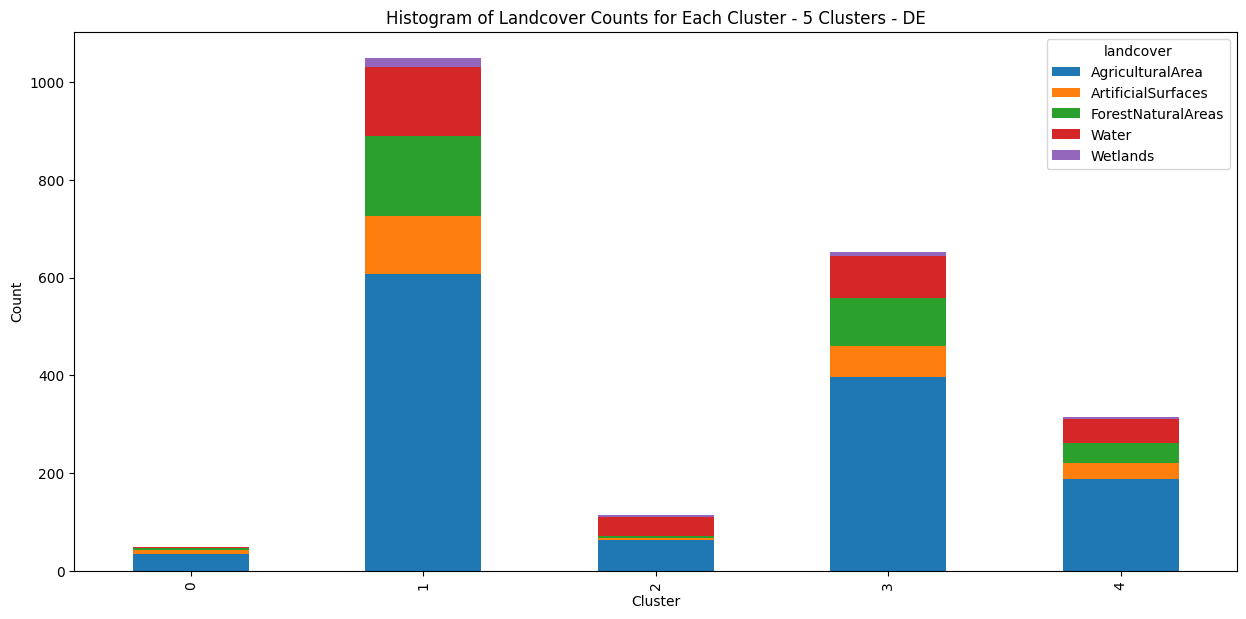

In [28]:
# Plot the histograms
hist = histogram_data.plot(kind='bar', stacked='True', figsize=(15,7))
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title(f'Histogram of Landcover Counts for Each Cluster - {n_clusters} Clusters - {countrycode}')
plt.savefig(f'histogram_plot_{n_clusters}clusters_{countrycode}.png')
plt.show()

Below are the observed results from both countries (using 5 clusters following the amount of landcover types).

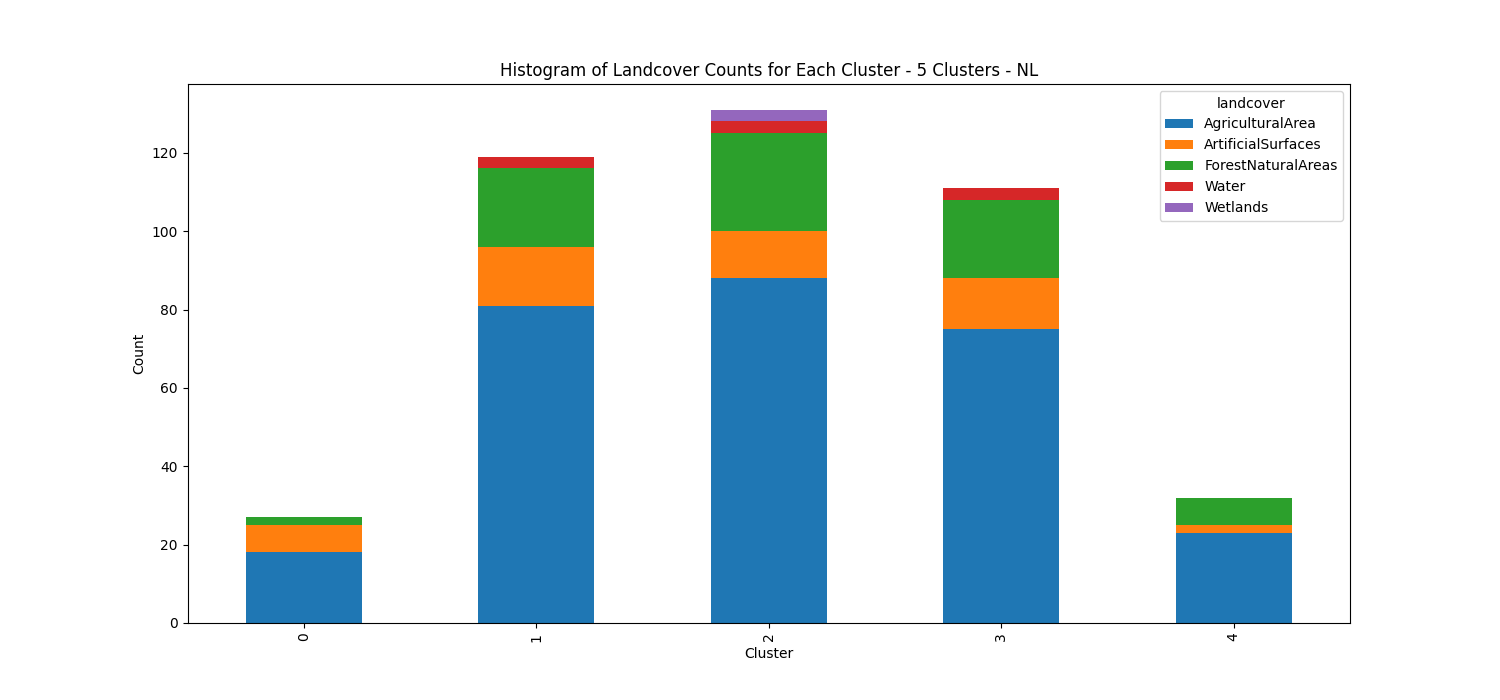

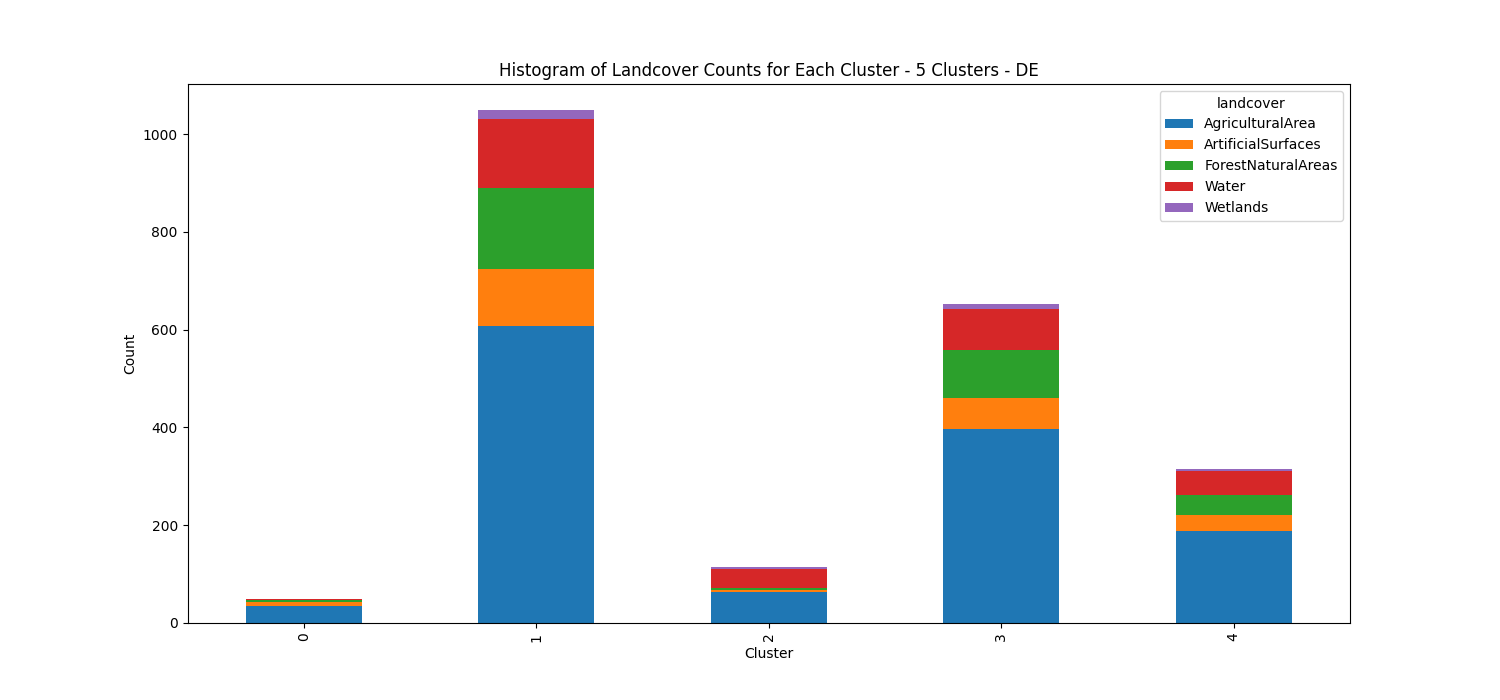

As shown from the histograms above, the region X training model used in Region Y shows the similar result — Agricultural Area being the dominant landcover types in each clusters. Meanwhile, despite using the same training model, most of The Netherlands area falls into Cluster [2] category while most of Germany area falls to Cluster [1].

This test shows that the training model from different area can be used to another region, obviously with careful considerations such as both areas having the same characteristics e.g. both The Netherlands and Germany have similar landcover types.

We were unable to apply the training model from Region X to Region Y that has more landcover types. The only countries with more than 5 landcover types are Russia and Italy which both have exactly the same landcover types as the Netherlands but with additional NaN type. This might be caused by blank record on both countries. Because NanN is not really a landcover type, and those NaN records have to be ignored to let the clustering works as it should, practically there is no country with more than 5 real landcover types to perform this subtask.